# Customized or remote execution of workflows

* **Difficulty level**: intermediate
* **Time need to lean**: 30 minutes or less
* **Key points**:
  * Option `-r host` executes workflow on `host`, optionally through a `workflow_template` specified through host configuration.
  * The remote host could be a regular server, or a cluster system, in which case the workflow could be executed using multiple computing nodes.
  * Local and remote hosts should share directories (e.g. via NFS mount) for input and output files.

Option `-r host` executes workflow on `host`. Depending on the properties of `host`, this option allows you to

1. Execute workflows locally, but in a customized environment
2. Execute workflows on a remote server directly
3. Execute entire workflows on a remote cluster system with option `-r`
3. Execute entire workflows on a remote cluster system with job submission with options `-r`, `-q`

Please refer to [host configuration](host_setup.html) for details on host configuration.

## Customized local environment for workflow execution

Assuming a system with two R versions, a system R installation under `/usr/local/bin` and a local installation in a conda environment. The latter version is the default version but if for some reasons the system R is preferred (e.g. if a library is only available there), you can change the local `PATH` of the `R` action using an `env` option (see [SoS actions](sos_actions.html) for details.

In [1]:
R:
    R.Version()$version.string

[1] "R version 3.6.1 (2019-07-05)"


In [2]:
import os

R: env={'PATH': f"/usr/local/bin:{os.environ['PATH']}"}
    R.Version()$version.string

[1] "R version 3.5.2 (2018-12-20)"


This action level `env` configuration is very flexible (e.g. you can use different versions of R in the same workflow) but can be difficult to maintain if you have multiple `R` actions. If your intent to use the same version of R throughout the workflow, it is easier to execute the entire workflow in a customized environment.

To achieve this, you can define a host as follows, which has a default `address` of `localhost`.

In [3]:
%save myconfig.yml -f
hosts:
  system_R:
    workflow_template: |
      export PATH=/usr/local/bin:$PATH
      {command}            

Cell content saved to myconfig.yml, use option -r to also execute the cell.

Then, we will be using the conda version of R by default

In [4]:
%run -v1
R:
    R.Version()$version.string

[1] "R version 3.6.1 (2019-07-05)"


and be using the system R if we execute the workflow in the `system_R` host with option `-r`, despite the fact that `system_R` is just a localhost with a template

In [5]:
%run -r system_R -c myconfig.yml -v1
R:
    R.Version()$version.string

[1] "R version 3.5.2 (2018-12-20)"


As you can imagine, the template can set up a variety of different environment such as conda environments, debug environments, and using `module load` on a cluster system.

## Execution of workflow on a remote host

If the `host` is a real remote host, then

```bash
sos run script workflow -r host [other options]
```
would execute the entire workflow on the `host`.

This option is useful if you would like to **write the entire workflow for a remote host and execute the workflow with all input, software, and output files on the remote host**. Typical use cases for this option are when the data is too large to be processed locally, or when the software is only available on the remote host.

For example, with a host definition similar to

```
hosts:
  bcb:
    address:  myserver.utexas.edu
    paths:
      home: /Users/bpeng1/scratch
```

the following cell execute the workflow on `bcb`

In [6]:
%run -r bcb
R:
  set.seed(1)
  x <- 1:100
  y <- 0.029*x + rnorm(100)
  png("test.png", height=400, width=600)
  plot(x, y, pch=19, col=rgb(0.5, 0.5, 0.5, 0.5), cex=1.5)
  abline(lm(y ~ x))
  dev.off()


INFO: No matching tasks are identified. Use option -a to check all tasks.
INFO: Running default: 
null device 
          1 
INFO: default is completed.
INFO: Workflow default (ID=94ec1bfb48adfe06) is executed successfully with 1 completed step.


The resulting `test.png` are generated on `bcb` and is unavailable for local preview. You can however preview the file with `-r` option of magic `%preview`

> test.png (30.5 KiB):

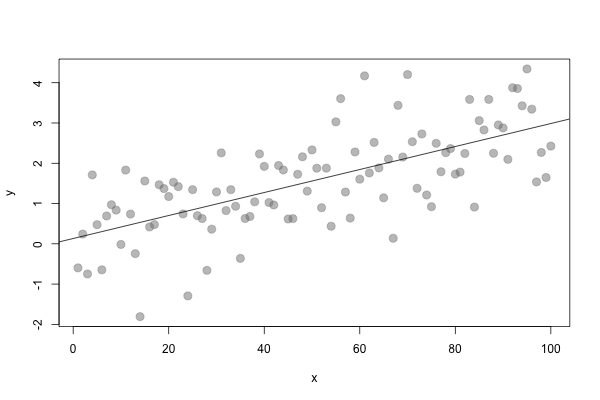

In [7]:
%preview -n test.png -r bcb

In this case we do not define any `workflow_template` for `bcb` so the workflow is executed directly on `bcb`. If a `workflow_template` is defined, the workflow will be executed through the shell script that is expanded from the template.

Note that local configrations, including the ones specified with option `-c` will be transferred and used on the remote host, with only the `localhost` definition switched to be the remote host. It is therefore safe to use local configurations with option `-r`.

## Executing entire workflows on remote cluster systems

If the remote host specified by option `-r host` is a cluster system, the workflow will be submitted to the cluster as a regular cluster job. The `workflow_template` of `host` will be used, using options specified from command line (`-r host KEY=VALUE KEY=VALUE`.

If `node=1`, sos will be executed with a single node, similar to what will happen if you execute the command locally. If `node=n` is specified, the workflow will be executed in a multi-node mode with `-j` automatically expanded to include remote workers that are assigned to the cluster job. see [option `-j`](verbosity_and_jobs.html) for details.

Because no `-q` option is specified, all tasks will be executed as regular substeps (as long as no `queue=` option is specified) and be executed to the cluster nodes for execution. This method is most efficient for the execution of a large number of small tasks because there is no overhead for the creation and execution of external tasks. It is less efficient for workflows with varying "sizes" of tasks because all computing nodes may have to wait for one computing node to execute one substep. In which case the follow execution method, namely submiting additional tasks from computing nodes could be better.

In [2]:
## Executing entire workflows on remote cluster systems with job submission

We already discussed the [use of option `-q` to submit tasks to remote hosts or cluster systems](task_statement.html). The key idea is that **the workflow is executed locally**. The main sos process will monitor and wait for the completion of remote tasks, and continue after the completion of the remote tasks. Because tasks are executed separately, it can be safely killed and resumed, which is one of the main advantages of the SoS task execution model.

It becomes a bit tricky to submit the workflow to a cluster system while allowing the master sos process, now executed on a computing node, to submit additional jobs. The command can be as simple as

```
sos run script -r host -q host
```

but things can go wrong if you do not understand completely what is happening:

1. With option `-r`, the entire workflow is executed on `host`. Since `host` has a PBS queue, the workflow will be submitted as a regular cluster job. **The resources needed for the master job needs to be specified from command line and expanded in `workflow_template`**.
2. The master `sos` process will be executed with a **transferred local config** on a computing node, with an option `-q host`. Now, because the `localhost` is set to `host` by the `-r` option, the cluster will appear to be a localhost to the `sos`, but with a different IP address etc.
3. The `sos` process will try to submit the tasks to the headnode through commands similar to `ssh host qsub job_id`. It is therfore mandatary that the `host` can be accessed with the specified `address` from the computing nodes. This is usually not a problem but it is possible that the headnode has different outfacing and inward addresses, in which case you will have to define a different `host` for option `-q`.

 ```yaml
 hosts:
     htc:
        address: htc_cluster.mdanderson.edu
        description: HTC cluster (PBS)
        queue_type: pbs
        status_check_interval: 60
        submit_cmd: qsub {job_file}
        status_cmd: qstat {job_id}
        kill_cmd: qdel {job_id}        
        nodes: 2
        cores: 4
        walltime: 01:00:00
        mem: 4G
        workflow_template: |
            #!/bin/bash
            #PBS -N {job_name}
            #PBS -l nodes={nodes}:ppn={cores}
            #PBS -l walltime={walltime}
            #PBS -l mem={mem}
            #PBS -m n
            module load R
            {command}
        task_template: |                
            #!/bin/bash
            #PBS -N {job_name}
            #PBS -l nodes={nodes}:ppn={cores}
            #PBS -l walltime={walltime}
            #PBS -l mem={mem//10**9}GB
            #PBS -o ~/.sos/tasks/{task}.out
            #PBS -e ~/.sos/tasks/{task}.err
            #PBS -m n            
            module load R
            {command}
```            